In [1]:
from kafka import KafkaProducer
import os
import logging
import psutil
import time


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


topic = os.environ.get('KAFKA_TOPIC', "cpu-logger")
logger.info(f"Kafka topic: {topic}")

_producer = None
try:
    _producer = KafkaProducer(bootstrap_servers=os.environ.get('KAFKA_BROKER', 'broker1:9093').split(","), 
                              api_version=(0, 10),
                              max_block_ms=10000)
except Exception as ex:
    logger.error('Exception while connecting Kafka', exc_info=True)

    
time_measurements = []
num_runs = 600 # this is 5 minutes worth of data
run = 0
loops = 100

while run < num_runs:
    start = time.time()
    for i in range(loops):
        try:
            message = ','.join([str(p) for p in psutil.cpu_percent(interval=0, percpu=True)])
            value_bytes = bytes(message, encoding='utf-8')
            _producer.send(topic=topic, 
                           value=value_bytes)
            _producer.flush()
            #logger.info('Message published successfully.')
        except Exception as ex:
            logger.error('Exception in publishing message', exc_info=True)
    end = time.time()
    time_measurements.append({"count": loops, "dur": end-start})
    if run % 10 == 0:
        print(f"Run {run} done!")
    run += 1

    time.sleep(0.5)

print("Done with logging")

INFO:__main__:Kafka topic: cpu-logger
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=broker1:9093 <connecting> [IPv4 ('172.18.0.6', 9093)]>: connecting to broker1:9093 [('172.18.0.6', 9093) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=broker1:9093 <connecting> [IPv4 ('172.18.0.6', 9093)]>: Connection complete.
INFO:kafka.conn:<BrokerConnection node_id=1 host=broker1:9093 <connecting> [IPv4 ('172.18.0.6', 9093)]>: connecting to broker1:9093 [('172.18.0.6', 9093) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=1 host=broker1:9093 <connecting> [IPv4 ('172.18.0.6', 9093)]>: Connection complete.
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=broker1:9093 <connected> [IPv4 ('172.18.0.6', 9093)]>: Closing connection. 


Run 0 done!
Run 10 done!
Run 20 done!
Run 30 done!
Run 40 done!
Run 50 done!
Run 60 done!
Run 70 done!
Run 80 done!
Run 90 done!
Run 100 done!
Run 110 done!
Run 120 done!
Run 130 done!
Run 140 done!
Run 150 done!
Run 160 done!
Run 170 done!
Run 180 done!
Run 190 done!
Run 200 done!
Run 210 done!
Run 220 done!
Run 230 done!
Run 240 done!
Run 250 done!
Run 260 done!
Run 270 done!
Run 280 done!
Run 290 done!
Run 300 done!
Run 310 done!
Run 320 done!
Run 330 done!
Run 340 done!
Run 350 done!
Run 360 done!
Run 370 done!
Run 380 done!
Run 390 done!
Run 400 done!
Run 410 done!
Run 420 done!
Run 430 done!
Run 440 done!
Run 450 done!
Run 460 done!
Run 470 done!
Run 480 done!
Run 490 done!
Run 500 done!
Run 510 done!
Run 520 done!
Run 530 done!
Run 540 done!
Run 550 done!
Run 560 done!
Run 570 done!
Run 580 done!
Run 590 done!
Done with logging


In [2]:
len(time_measurements)

600

In [3]:
import numpy as np
import pandas as pd

df = pd.DataFrame(time_measurements[0:num_runs])
df.sample(10)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,count,dur
107,100,0.097180
231,100,0.121699
370,100,0.096483
172,100,0.115778
201,100,0.133921
16,100,0.139009
80,100,0.120838
317,100,0.108122
60,100,0.088441
316,100,0.095972


In [4]:
desc = df["dur"].describe()
desc

count    600.000000
mean       0.117490
std        0.018154
min        0.087933
25%        0.101728
50%        0.114293
75%        0.131479
max        0.200397
Name: dur, dtype: float64

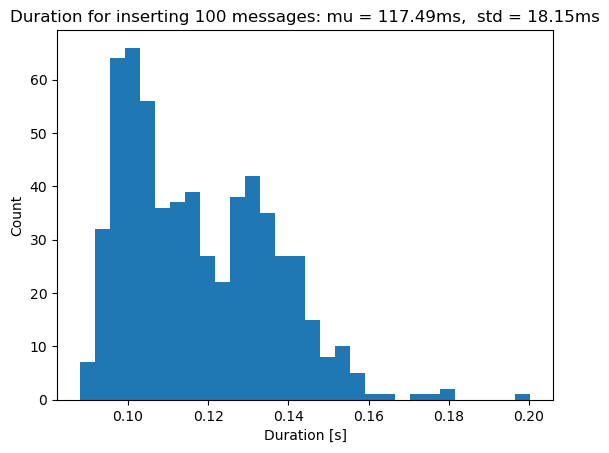

In [6]:
# plot a histogram
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.hist(df['dur'], bins=30)
plt.ylabel('Count')
plt.xlabel('Duration [s]')
title = f"Duration for inserting {loops} messages: mu = {desc['mean']*1000:.2f}ms,  std = {desc['std']*1000:.2f}ms"
plt.title(title)
plt.show()